In [8]:
import re

import jsonlines
import pandas as pd
import numpy as np
import difflib

In [2]:
# # TODO: load metadata and return aggregate / summary statistics

logged_metadata = []

with jsonlines.open('../metadata/covers.jsonl', mode='r') as reader:
    for item in reader:
        logged_metadata.append(item)
        
df = pd.DataFrame(logged_metadata)

In [3]:
def get_issue_number_from_title(title):
    issue = re.search(r"([#?])(\d+)\b", title.replace(',', ''))
    if issue is None:
        return np.nan
    else:
        return np.int(issue.group().replace('#', ''))

df['issue_number'] = df['title'].apply(get_issue_number_from_title)

df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,21434,53,Saddle-stitched,8751
format_color,21434,25,Color,11566
format_dimensions,21434,67,standard Modern Age US,4548
format_paper_stock,21434,72,,6120
format_publishing_format,21434,46,was ongoing series,8413
indexer_notes,21434,13476,,3378
indicia_frequency,21434,494,monthly,11049
issue_brand,21434,118,DC [bullet],3938
issue_indicia_publisher,21434,77,DC Comics,5308
issue_pages,21434,97,36,15015


In [9]:
flatten = lambda l: [item for sublist in l for item in sublist]

def match_brackets(characters: str):
    p = re.compile(r"\[(.*?)\]")
    matches = {}
    for m in p.finditer(characters):
        matches[m.group()] = {"start": m.start(), "end": m.end()}
    return matches


def replace_semicolons_in_brackets(characters: str):
    p = re.compile(r"\[(.*?)\]")
    matches = []
    for m in p.finditer(characters):
        matches.append((m.start(), m.end(), m.group()))
    for match in matches:
        substring = characters[match[0]: match[1]]
        if substring.count(";") == 1 and (("Kal-El" in substring) |  ("Zor-El" in substring)):
            characters = characters.replace(substring,  substring.replace(";", "/"))
        if substring.count(";") > 1:
            pass
    return characters


def look_behind(t, end_idx):
    span = t[: (end_idx - 1)]
    semicolon_matches = [(m.group(),m.start(),m.end()) for m in re.finditer(r"(?<=(;))", span)]
    if len(semicolon_matches) ==  0:
        start_idx = 0
    else:
        start_idx = semicolon_matches[-1][2]
    return span[start_idx: end_idx].strip()

def convert_character_dict_to_str(character_dict):
    return  str(character_dict["Teams"]).\
    replace("{", "").\
    replace("}", "").\
    replace("'", "").\
    replace(",", ";")

def diff_strings(string1,  string2):
    diff = ""
    for idx, val in enumerate(difflib.ndiff(string1, string2)):
        if val[0] == "+":
            diff += val[2]
    return diff

In [10]:
def convert_characters_to_list(t):
    
    t = replace_semicolons_in_brackets(t)

    stack = 0
    startIndex = None
    results = []

    matches = []
    for i, c in enumerate(t):
        if c == '[':
            if stack == 0:
                startIndex = i + 1 # string to extract starts one index later

            # push to stack
            stack += 1
        elif c == ']':
            # pop stack
            stack -= 1

            if stack == 0:
                matches.append((startIndex, i))
                results.append(t[startIndex:i])

    character_dict = {}
    character_dict["Teams"] = {}
    character_dict["Individuals"] = {}

    for span in matches:
        entity = t[span[0]: span[1]]
        if entity.count(";") == 0:
            person_name = look_behind(t, span[0])
            person_identity = entity
            character_dict["Individuals"][person_name] = person_identity

        elif entity.count(";") > 1:
            team_name = look_behind(t, span[0])
            team_members = list(filter(lambda x: x != "", entity.split("; ")))
            character_dict["Teams"][team_name] = team_members


    team_string = convert_character_dict_to_str(character_dict)

    remainder = diff_strings(team_string, t)

    remainder = list(filter(lambda x: x != "", remainder.split("; ")))

    character_dict["Individuals"] = remainder

    character_list = []
    for k in character_dict["Teams"]:
        character_list.append(character_dict["Teams"][k])

    character_list.append(character_dict["Individuals"])

    return flatten(character_list)

In [11]:
# #  list of all characters
# characters = list(df_covers["cover_characters"].dropna().values)

# test = characters[11_150]

# print(test)
# convert_characters_to_list(test)

In [12]:
# create cover df
df_covers = pd.concat(df['covers'].apply(lambda x: pd.DataFrame(x).T).tolist(), axis=0).reset_index(drop=True)

# create cover characters df
df_cover_characters = df_covers[df_covers["cover_characters"].notnull()].copy().reset_index(drop=True)
df_cover_characters["cover_characters_list"] = df_cover_characters["cover_characters"].apply(convert_characters_to_list)

In [13]:
# # TODO: consolidate names of characters labeled on covers to reduce fragmentation in label space

print("Cover Characters:")

list(zip(pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:100].index,
    pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts()[:100].values))

Cover Characters:


[('Superman', 1355),
 ('Batman [Bruce Wayne]', 1140),
 ('Iron Man [Tony Stark]', 1077),
 ('Spider-Man [Peter Parker]', 992),
 ('Thor', 871),
 ('Wolverine', 776),
 ('Batman', 726),
 ('Captain America [Steve Rogers]', 682),
 ('Hulk [Bruce Banner]', 633),
 ('Human Torch [Johnny Storm]', 597),
 ('Superman [Clark Kent/ Kal-El]', 564),
 ('Wonder Woman', 521),
 ('Cyclops', 519),
 ('Conan', 516),
 ('Robin [Dick Grayson]', 378),
 ('Superman [Clark Kent]', 348),
 ('Beast', 347),
 ('Superboy', 340),
 ('Vision', 330),
 ('Lois Lane', 319),
 ('Storm', 315),
 ('Iceman', 299),
 ('Spider-Man', 289),
 ('Mr. Fantastic', 280),
 ('Hulk', 255),
 ('Colossus', 250),
 ('Wonder Woman [Diana Prince]', 247),
 ('Hercules', 235),
 ('Aquaman', 233),
 ('Punisher', 223),
 ('The Thing [Ben Grimm]', 223),
 ('The Thing', 221),
 ('Cable', 219),
 ('Mr. Fantastic [Reed Richards]', 218),
 ('Nightwing', 211),
 ("'", 208),
 ('Thor [Donald Blake]', 207),
 ('Namor, the Sub-Mariner', 203),
 ('Angel', 200),
 ('Joker', 198),
 ('Nig

In [ ]:
# define character groupings

["Superman",  "Superman [Clark Kent/ Kal-El]", "Superman [Clark Kent]"]

["Wonder Woman", "Wonder Woman [Diana Prince]", "Wonder Woman [Diana]"]

["The Thing", "The Thing [Ben Grimm]"]

In [23]:
unique_characters = pd.Series(flatten(df_cover_characters["cover_characters_list"].values)).value_counts().index

list(unique_characters)[:20]

['Superman',
 'Batman [Bruce Wayne]',
 'Iron Man [Tony Stark]',
 'Spider-Man [Peter Parker]',
 'Thor',
 'Wolverine',
 'Batman',
 'Captain America [Steve Rogers]',
 'Hulk [Bruce Banner]',
 'Human Torch [Johnny Storm]',
 'Superman [Clark Kent/ Kal-El]',
 'Wonder Woman',
 'Cyclops',
 'Conan',
 'Robin [Dick Grayson]',
 'Superman [Clark Kent]',
 'Beast',
 'Superboy',
 'Vision',
 'Lois Lane']

In [31]:
name = "Superman"

list(filter(lambda x: x is not None, [x if name in x else None for x in unique_characters]))

['Superman',
 'Superman [Clark Kent/ Kal-El]',
 'Superman [Clark Kent]',
 'Superman [Clark Smith]',
 'Superman [Kal-El]',
 'Superman Blue',
 'Cyborg Superman',
 'Cyborg Superman [Hank Henshaw]',
 'Superman [Kal-El/ Clark Kent]',
 'Superman Red',
 'Superman (Earth-2)',
 'Superman [Kal Kent/ Kal-El]',
 'Superman [Clark Kent] (Earth-2)',
 'Clark Kent [Superman/ Kal-El]',
 'Cyborg Superman [Zor-El]',
 'Clark Kent [Superman]',
 'Superman Blue [Clark Kent/ Kal-El]',
 'Superman [Harvey Dent] (Earth-9)',
 'Superman [Clark Kent] (Earth 2)',
 'Superman [President Calvin Ellis',
 'Superman [Billy Batson]',
 'unnamed Superman-type super-villain',
 'Superman [Kal Kent]',
 'Superman [Conner Kent] (From the future)',
 'Last Son of Krypton [as Superman]',
 'Superman [Clark Jones]',
 'Superman statue',
 'Superman (Earth-2, guest star)',
 'Superman (Earth-2, inset)',
 'Superman (poster)',
 'Superman (actually nanites from Jazuur)',
 'Superman (of Earth-1)',
 'Composite Superman',
 'Superman [Clark Kent]

In [36]:
# # TODO: write method to display cover image w/ cover metadata and add annotations to image
# # TODO: consider ideate/innotater for annotating directly in Jupyter notebooks

import os

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance

covers = os.listdir('../covers/')

dims = []
for cover in covers:
    im = Image.open('../covers/' + cover)
    width, height = im.size
    dims.append((width, height))
    
"Calculated dims for {} covers".format(len(dims))

'Calculated dims for 27256 covers'

In [39]:
n = 60
pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
top_dims

print('Top Image Sizes:')
print(top_dims.values, '\n')
print('Height distribution:')
print('mean', round(pd.Series(map(lambda x: x[1], top_dims)).mean(), 0))
print('median', round(pd.Series(map(lambda x: x[1], top_dims)).median(), 0))
print('min', round(pd.Series(map(lambda x: x[1], top_dims)).min(), 0))
print('max', round(pd.Series(map(lambda x: x[1], top_dims)).max(), 0))
print('std', round(pd.Series(map(lambda x: x[1], top_dims)).std(), 0))

Top 60 image sizes account for 94.6% of covers 

Top Image Sizes:
[(400, 615) (400, 616) (400, 614) (400, 618) (400, 617) (400, 613)
 (400, 619) (400, 612) (400, 620) (400, 607) (400, 611) (400, 610)
 (400, 621) (400, 608) (400, 622) (400, 609) (400, 606) (400, 623)
 (400, 604) (400, 624) (400, 600) (400, 605) (400, 603) (400, 601)
 (400, 602) (400, 625) (400, 598) (400, 597) (400, 626) (400, 596)
 (400, 599) (400, 595) (400, 594) (400, 591) (400, 593) (400, 627)
 (400, 628) (400, 590) (400, 592) (400, 588) (400, 589) (400, 546)
 (400, 587) (400, 629) (400, 584) (400, 586) (400, 634) (400, 585)
 (400, 583) (400, 581) (400, 579) (400, 630) (400, 578) (400, 582)
 (400, 577) (400, 580) (400, 576) (400, 631) (400, 573) (400, 567)] 

Height distribution:
mean 602.0
median 602.0
min 546
max 634
std 19.0


In [43]:
def resize_im(im, dims):
    return im.resize(dims)

def save_im(im, save_directory, im_type):
    im.save(save_directory, im_type)
    
def get_im_rgb(im, size):
    rgb_im = im.convert('RGB')
    rgb = []
    for x in range(1, size[0]):
        for y in range(1, size[1]):
            rgb.append(rgb_im.getpixel((x, y)))
    dtypes = np.dtype('int, int, int')
    return np.array(rgb, dtype=dtypes)

../covers/Thor: First Thunder: Thor: First Thunder #5 Original (2011-01-19).jpg


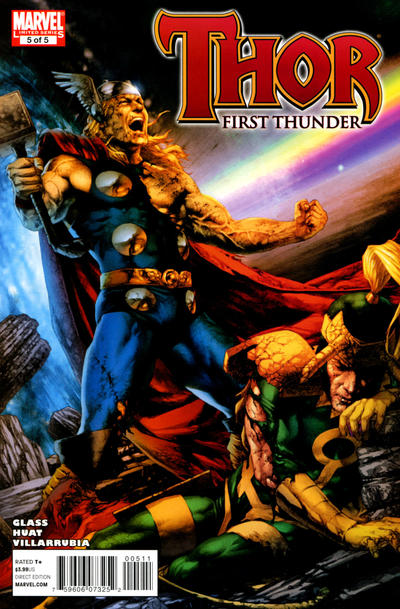

In [44]:
cover_idx = 1000

print('../covers/' + covers[cover_idx])
im = Image.open('../covers/' + covers[cover_idx])
im

In [ ]:
# # TODO: Filter cover spreads

# import numpy as np

# for i in range(0, len(covers)):
#     im = Image.open('../covers/' + covers[i])
#     width, height = im.size
#     if (height < 565.0) | (height > 637.0):
#         pass
#     else:
#         im_resize = resize_im(im, (400, 614))
#         im_resize.save('../covers_filtered/' + covers[i])

In [ ]:
# # TODO: Dedupe covers

In [16]:
def get_value_counts(df, column):
    return pd.Series("; ".join(df[column].\
                               dropna()).\
                     replace(" (signed)", "").\
                     replace(" (painted)", "").\
                     split('; ')).value_counts()

print("Cover Artists:")

list(zip(get_value_counts(df_covers, 'cover_pencils')[:100].index, 
         get_value_counts(df_covers, 'cover_pencils')[:100].values))

Cover Artists:


[('Gil Kane', 538),
 ('Jack Kirby', 529),
 ('Curt Swan', 420),
 ('?', 412),
 ('John Buscema', 368),
 ('John Byrne', 353),
 ('Alex Ross', 339),
 ('George Pérez', 293),
 ('John Romita', 251),
 ('Rich Buckler', 243),
 ('Ross Andru', 239),
 ('Nick Cardy', 227),
 ('Salvador Larroca', 196),
 ('Neal Adams', 191),
 ('Ron Frenz', 180),
 ('Herb Trimpe', 179),
 ('Brian Bolland', 174),
 ('Paul Ryan', 161),
 ('Tom Grummett', 152),
 ('Adam Kubert', 142),
 ('Andy Kubert', 141),
 ('Terry Dodson', 136),
 ('Dan Jurgens', 134),
 ('Leinil Francis Yu', 130),
 ('Ryan Ottley', 123),
 ('Jim Aparo', 123),
 ('Greg Capullo', 123),
 ('Win Mortimer', 123),
 ('Mike McKone', 121),
 ('Al Milgrom', 121),
 ('Walt Simonson', 119),
 ('Scott McDaniel', 116),
 ('Wayne Boring', 113),
 ('Ed McGuinness', 111),
 ('Humberto Ramos', 111),
 ('Ron Wilson', 110),
 ('Mark Bagley', 110),
 ('Dave Cockrum', 108),
 ('Sheldon Mayer', 107),
 ('Bob Layton', 104),
 ('Jim Lee', 102),
 ('David Finch', 101),
 ('Alan Davis', 98),
 ('Paul Pellet

In [ ]:
def create_training_dirs():
    """
    Given some args, create two compressed files: images.tar.gz & annos.tar.gz
    """